# MCMC Comparison

## surmise

1. Train a GP (using surmise) to emulate the ${}^3{\rm He}(\alpha,\gamma)$ observables. 
2. Use that GP to calculate the $R$-matrix parameter posteriors.
3. Compare to the results in our BRICK paper.


* CS model
* maximally 1000 training points

In [2]:
import os
import subprocess

import numpy as np
import matplotlib.pyplot as plt
from corner import corner
import seaborn as sns
import emcee
import dill as pickle

import model
from bayes import ln_prior, Model

In [3]:
plt.style.use('science')
gr = (1 + np.sqrt(5)) / 2
h = 3

plt.rcParams['figure.dpi'] = 150

In [4]:
b = emcee.backends.HDFBackend('emulators/backends/eps_1.0000e-02_ntrain_500_fat_0.3.h5')

with open('emulators/emu_eps_1.0000e-02_ntrain_500_fat_0.3.pkl', 'rb') as f:
    emu = pickle.load(f)

In [5]:
emu._info['pc'].shape

(500, 95)

In [6]:
design_chain = np.load('datfiles/posterior_chain.npy')
desing_points = np.load('datfiles/posterior_samples.npy')

In [7]:
design_chain.shape

(1000, 32)

In [8]:
m = Model(emu)

In [12]:
def likelihood_normalization(theta):
    mu, var = m.gp_predict(theta[:16])
    return m.likelihood_normalization(model.dy**2 + var)


def chi_squared(theta):
    f = m.normalization_factors(theta)
    mu, var = m.gp_predict(theta[:16])
    return m.chi_squared(f, mu, var)

In [14]:
flat_chain = b.get_chain(flat=True)

In [20]:
lnl_norm = np.array([likelihood_normalization(theta) for theta in design_chain[-1000:]])
chisq = np.array([chi_squared(theta) for theta in design_chain[-1000:]])

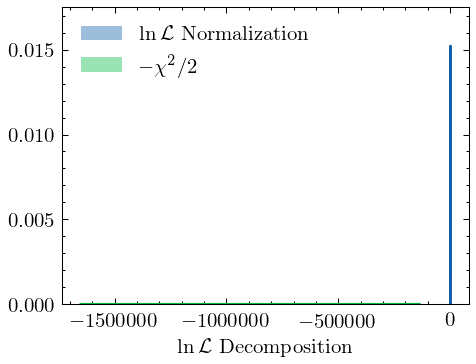

In [21]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')

sns.distplot(lnl_norm, ax=ax, label=r'$\ln\mathcal{L}$ Normalization')
sns.distplot(chisq, ax=ax, label=r'$-\chi^2/2$')

ax.legend()
ax.set_xlabel(r'$\ln\mathcal{L}$ Decomposition');

In [10]:
n1 = model.nbr
n2 = model.nxs

In [11]:
flat_chain = b.get_chain(flat=True)
lnp = b.get_log_prob(flat=True)
theta_star = flat_chain[np.argmax(lnp), :]

In [12]:
lnp[np.argmin(lnp)]

-430831.1397296898

In [13]:
lnp.shape

(64000,)

In [14]:
theta_bad = flat_chain[np.argmin(lnp), :]

In [15]:
np.argmin(lnp)

50

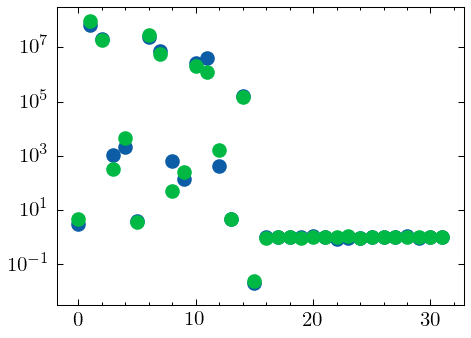

In [16]:
plt.scatter(np.arange(theta_bad.size), np.abs(theta_bad))
plt.scatter(np.arange(theta_star.size), np.abs(theta_star))
plt.yscale('log');

In [17]:
from bayes import ln_prior, Model

In [18]:
m = Model(emu)

In [19]:
m.ln_likelihood(theta_bad)

-430654.70702311397

In [20]:
m.ln_likelihood(theta_star)

574.492564143072

In [25]:
print(f'{m.ln_likelihood(theta_bad, include_gp_var=False):.4e}')
print(f'{m.ln_likelihood(theta_star, include_gp_var=False):.4e}')

-3.8215e+11
-2.5074e+10


In [26]:
from multiprocessing import Pool

In [27]:
with Pool(processes=16) as pool:
    lnpi = pool.map(ln_prior, flat_chain)

In [28]:
lnpi = np.array(lnpi)

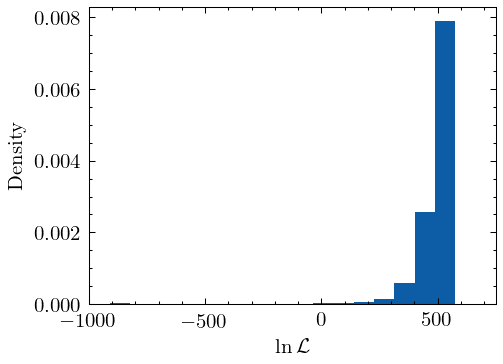

In [29]:
plt.hist(lnp[500:] - lnpi[500:],bins=200, density=True)
plt.xlim([-1000, 750])
plt.xlabel('$\ln\mathcal{L}$')
plt.ylabel('Density');

In [45]:
mu_star = model.calculate_norm(theta_star)
mu_bad = model.calculate_norm(theta_bad)

In [54]:
def plot_prediction(theta, ax, start, stop, color='C2', label=None):
    p = emu.predict(theta=theta[:16])
    mu = p.mean().flatten()
    var = p.var().flatten()
    ax.errorbar(model.x[start:stop], mu[start:stop], yerr=np.sqrt(var[start:stop]),
                linestyle='', capsize=2, color=color, marker='x', alpha=0.5, label=label)

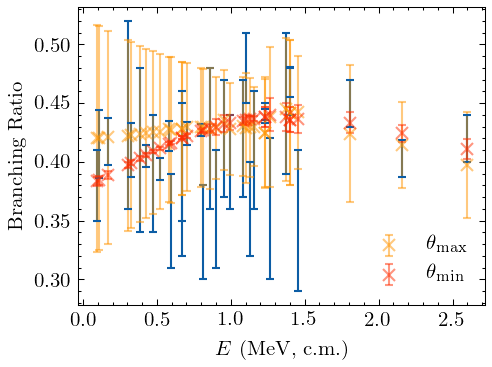

In [55]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')

ax.errorbar(model.x[:n1], model.y[:n1], yerr=model.dy[:n1], linestyle='', capsize=2)
# ax.scatter(model.x[:n1], mu_star[:n1], color='C1')
# ax.scatter(model.x[:n1], mu_bad[:n1], color='C1')

plot_prediction(theta_star, ax, 0, n1, label=r'$\theta_{\max}$')
plot_prediction(theta_bad, ax, 0, n1, color='C3', label=r'$\theta_{\min}$')
# ax.errorbar(model.x[:n1], mu_star_gp[:n1], yerr=np.sqrt(mu_star_gp_var[:n1]), linestyle='', capsize=2, color='C2')

ax.legend()
ax.set_ylabel('Branching Ratio')
ax.set_xlabel('$E$ (MeV, c.m.)');

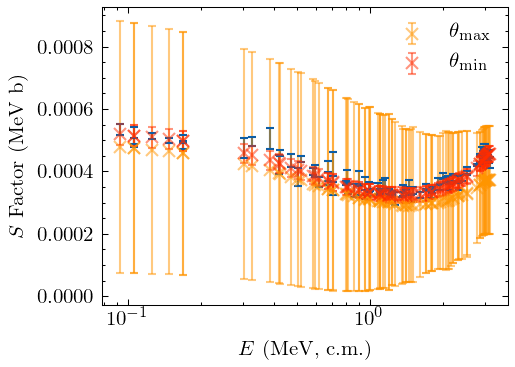

In [59]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')

ax.errorbar(model.x[n1:n1+n2], model.y[n1:n1+n2], yerr=model.dy[n1:n1+n2], linestyle='',
            capsize=2)

plot_prediction(theta_star, ax, n1, n1+n2, label=r'$\theta_{\max}$')
plot_prediction(theta_bad, ax, n1, n1+n2, color='C3', label=r'$\theta_{\min}$')
# ax.scatter(model.x[n1:n1+n2], 1000*mu_star[n1:n1+n2], color='C1')
# ax.errorbar(model.x[n1:n1+n2], 1000*mu_star_gp[n1:n1+n2], yerr=1000*np.sqrt(mu_star_gp_var[n1:n1+n2]), linestyle='',
#             capsize=2, color='C2')

ax.legend()
ax.set_ylabel('$S$ Factor (MeV b)')
ax.set_xlabel('$E$ (MeV, c.m.)')
ax.set_xscale('log');

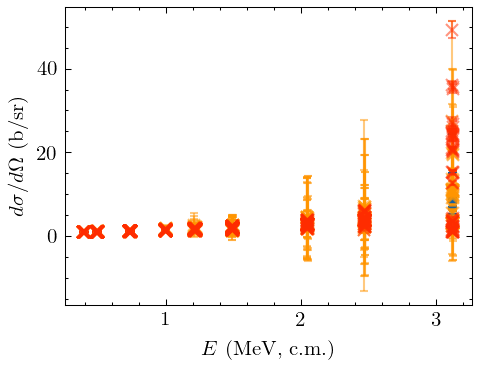

In [60]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')

ax.errorbar(model.x[n1+n2:], model.y[n1+n2:], yerr=model.dy[n1+n2:], linestyle='',
            capsize=2)

plot_prediction(theta_star, ax, n1+n2, None, label=r'$\theta_{\max}$')
plot_prediction(theta_bad, ax, n1+n2, None, color='C3', label=r'$\theta_{\min}$')

# ax.scatter(model.x[n1+n2:], mu_star[n1+n2:], color='C1')
# ax.errorbar(model.x[n1+n2:], mu_star_gp[n1+n2:], yerr=np.sqrt(mu_star_gp_var[n1+n2:]), linestyle='',
#             capsize=2, color='C2')

ax.set_ylabel(r'$d\sigma/d\Omega$ (b/sr)')
ax.set_xlabel('$E$ (MeV, c.m.)');